# CSE5CV Lab 02 - Classification with image features

In this week's lab we will cover:
  1. The purpose of classification.
  2. What a feature is, exactly, along with some disambiguation.
  3. Implementing a few popular image features.
  4. Sophisticated classification with simple library functions.

## Colab preparation

Google Colab is a free online service for editing and running code in notebooks like this one. To get started, follow the steps below:

1. Click the "Copy to Drive" button at the top of the page. This will open a new tab with the title "Copy of...". This is a copy of the lab notebook which is saved in your personal Google Drive. **Continue working in that copy, otherwise you will not be able to save your work**. You may close the original Colab page (the one which displays the "Copy to Drive" button).
2. Run the code cell below to prepare the Colab coding environment by downloading sample files. Note that if you close this notebook and come back to work on it again later, you will need to run this cell again.

In [ ]:
!git clone https://github.com/ltu-cse5cv/cse5cv-labs.git
%cd cse5cv-labs/Lab02

## Packages

In this lab, we will be using the following libraries:

1. *OpenCV* (`cv2`) to load images.
2. *Scikit-image* (`skimage`) to calculate image features.
3. *Scikit-learn* (`sklearn`) to classify based on image features.
4. *Torchvision* (`torchvision`) to download the CIFAR-10 dataset.

In [ ]:
# From python std lib
import math
from pathlib import Path

# Libraries
import cv2
import sklearn.svm
import sklearn.neighbors
import skimage.feature
import torchvision

import numpy as np
import matplotlib.pyplot as plt

# A toy dataset used throughout
fnames = [ 'inside_1.jpg', 'inside_2.jpg', 'outside_1.jpg', 'outside_2.jpg' ]
dataset = [ (fname, cv2.imread(fname)) for fname in fnames ]

Below is a brief introduction on *Scikit-image*. For information about the other libraries check the Libraries notebook available on LMS.

### Scikit-image

Scikit-image is a collection of algorithms for image processing.

Package Homepage: https://scikit-image.org/    
Python Documentation (v0.18.x): https://scikit-image.org/docs/0.18.x/api/api.html

We will use *Scikit-image* to collect image features.

# 1. Classification

Computer vision is about extracting meaningful information from images. Classification answers the question: Given some image, what is the most salient thing in it? Classification is the most fundamental task in computer vision, and all other computer vision tasks build on the concepts used for it.

We will discuss the other computer vision tasks in more detail later in the subject, but broadly speaking:
 - When some object is both found and classified in an image, we call that "detection".
 - When each pixel in an image is classified, we call that "segmentation".
 - When an individual of a class is distinguished between other individuals, e.g. facial recognition, we call that "identification". Although it is often implemented as a classification between identities.

Classification can also be useful in and of itself. e.g.:
 - Classifying medical images for fast or at-home diagnosis
 - Automatic image/video tagging for more efficient searching

# 2. Features

Before classifying images, let's first consider how we might classify a class of student's height into "tall", "medium" and "short". We can easily come up with some logic to do this. If their height is above some value, then they are "tall", etc.

In [ ]:
def classify_height(height):
    if height > 178:
        return 'tall'
    elif height > 162:
        return 'medium'
    else:
        return 'short'
for height in [155, 160, 165, 170, 175, 180, 185]:
    print(height, classify_height(height))

This is easy because there is only one parameter involved with making the decision, so it's clear how to decide. We may debate where the boundary lies, but we can easily understand the boundary.

Now, consider the space of all possible images of a certain size. Each pixel can hold a different value, and even small differences constitute a different image. A 32x32 RGB image has 3072 different pixels. Since each pixel can hold a value, we can say that an image is a single point in a 3072-D space. Let's put that statement into code.

In [ ]:
# Consider a 2x2 grayscale image.
img_g = np.array([[[0.3, 0.2], [0.7, 0.1]]])
img_g_vec = img_g.reshape(-1)
print(img_g.shape)
print(img_g_vec.shape)

print('-'*10)

# Consider a 32x32 RGB image.
img_c = np.random.randn(32, 32, 3)
img_c_vec = img_c.reshape(-1)
print(img_c.shape)
print(img_c_vec.shape)

</br>
<b>Question</b>: If we make a 32x32 <code>np.uint8</code> RGB image, how many different possible images are there? (answer as a calculation, rather than the resulting number)

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    There are 3072 pixels/dimensions to the space of possible values. Each <code>np.uint8</code> value has 2^8=256 different possible values. Then there are (2^8)^3072 possible distinct images.
</details>

</br>
<b>Question</b>: If we make a 32x32 <code>np.float32</code> RGB image, how many different possible images are there? (answer as a calculation, rather than the resulting number)

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    There are still 3072 pixels/dimensions to the space of possible values. But the range of possible values for each pixel is enormous: 2^32=6.8*10^38 different values. Then there are (2^32)^3072 possible distinct images. That's on the order of 10^29592 possible different images just for a 32x32!
</details>

## 2.1 Toy Dataset

With so many dimensions in our images, it will be difficult to determine how to make a decision about something complex like "is this an image of a dog?". This is called "the curse of dimensionality". In order to begin making decision boundaries for images, we need to reduce this complexity. As a naive example, let's try to reduce a whole image into a single number that represents that image and try to use similar logic to the above example. Consider the following dataset of 4 "inside" and "outside" images:

<table>
    <tr>
        <th>Inside 1</th>
        <th>Inside 2</th>
        <th>Outside 1</th>
        <th>Outside 2</th>
    </tr>
    <tr>
        <td><img src='https://raw.githubusercontent.com/ltu-cse5cv/cse5cv-labs/master/Lab02/inside_1.jpg' /></td>
        <td><img src='https://raw.githubusercontent.com/ltu-cse5cv/cse5cv-labs/master/Lab02/inside_2.jpg' /></td>
        <td><img src='https://raw.githubusercontent.com/ltu-cse5cv/cse5cv-labs/master/Lab02/outside_1.jpg' /></td>
        <td><img src='https://raw.githubusercontent.com/ltu-cse5cv/cse5cv-labs/master/Lab02/outside_2.jpg' /></td>
    </tr>
</table>

The code below reduces each image to a single number representing the average value of the green channel, and attempts to use that value to separate "inside" and "outside" images.

In [ ]:
def extract_feature_g(img):
    ''' Takes the average green value across the whole image. '''
    g_channel = img[:, :, 1]
    return g_channel.mean()

def classify_outside(feature):
    # Threshold determined manually from looking at the data in this case.
    threshold = 125
    if feature > threshold:
        return 'outside'
    else:
        return 'inside'

# Collect features
all_features = []
true_classes = []
for fname, img in dataset:
    feature = extract_feature_g(img)
    is_outside = classify_outside(feature)
    print(fname, feature, is_outside)
    all_features.append(feature)
    true_classes.append('outside' in fname)

# Plot this feature
fig, ax = plt.subplots(1, 1)
ax.scatter(all_features, [0]*len(all_features), c=true_classes)
ax.set_xlabel('Average green')
_ = ax.set_yticks([])

We can see that the rule works for "outside_2.jpg" and "inside_2.jpg", but not for "outside_1.jpg" or "inside_1.jpg". Note the variable name `feature` in the code. Essentially a feature is just a simpler representation of our image, ideally capturing something important from the image. That is, we deal with the curse of dimensionality with dimensionality reduction. **But** it's an imperfect solution. In this case, we have lost too much information from our image by reducing it to a single number to be able to classify correctly.

<details>
    <summary style='cursor:pointer;'><u>A closer look at the threshold condition.</u></summary>
    Our condition says "if there is more than an average of 125 green per pixel, then it's considered 'outside', and then, Inside 2 and Outside 1 are clearly more green than the others, but are classified as "Inside". You may initially have expected it to be other way around. What's going on?
    <br />
    Well, this is an example of where our feature didn't measure what you expected it would. Remember that pure white in an image has maximal green, too. Inside 2 and Outside 1 are noticably darker (many more shadows), so their absolute green values are actually much lower than the others. You could try to measure <i>relative</i> green values, but that also wouldn't be useful to distinguish between Inside 2 and Outside 1. Creating good features is hard.
</details>

<b>Question</b>: Can we modify `threshold` so that `classify_outside` works for all of our test images?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    We cannot choose a single value for threshold that works for all of our images. We could make <code>classify_outside</code> more complex and get perfect accuracy on these images, but it's clear that this would fail for most other images.
</details>


**Task**: Modify the below code to use the mean value of both green and red. You should be able to classify  all 4 images correctly. The solution is hidden below.
**Important**: This task is **not** how you should create a classifier in the real world. Hopefully you see how fragile this method is. Later in the lab we'll show you good classifiers to use. This is just used for illustrative purposes.

**Reminder**: Images in *OpenCV* are loaded from disk in BGR format.

In [ ]:
def extract_feature_g(img):
    ''' Takes the average green value across the whole image. '''
    g_channel = img[:, :, 1]
    return g_channel.mean()
def extract_feature_r(img):
    ''' Takes the average red value across the whole image. '''
    # TODO
    return 0

def classify_outside(features):
    # Threshold determined manually from looking at the data in this case.
    # TODO - add extra branches to cover our cases
    if features[0] < 125:
        return 'outside'
    else:
        return 'inside'

# Collect features
all_features = []
true_labels = []
for fname, img in dataset:
    # Get features and classification
    features = [extract_feature_g(img), extract_feature_r(img)]
    is_outside = classify_outside(features)

    # Print features and classification
    print(f'{fname:20s}', f'g: {features[0]:3.0f}  r: {features[1]:3.0f}', '    ', is_outside)

    # Append features and true labels
    all_features.append(features)
    true_labels.append('outside' in fname)

# Plot these features against one another
all_features = np.array(all_features)
fig, ax = plt.subplots(1, 1)
ax.scatter(all_features[:, 0], all_features[:, 1], c=true_labels)
ax.set_xlabel('Average green')
_ = ax.set_ylabel('Average red')

#### Task solution

In [ ]:
def extract_feature_g(img):
    ''' Takes the average green value across the whole image. '''
    g_channel = img[:, :, 1]
    return g_channel.mean()
def extract_feature_r(img):
    ''' Takes the average red value across the whole image. '''
    r_channel = img[:, :, 2]
    return r_channel.mean()

def classify_outside(features):
    # Threshold determined manually from looking at the data in this case.
    # Solution #1 - Fitting a line
    # Rise/run * x on graph - some constant > y on graph
    if 35/15*features[0]-167 > features[1]:
        return 'inside'
    else:
        return 'outside'
    # Solution #2 - Manual rules per image
    if features[1] < 100:
        return 'outside'
    elif features[1] > 140:
        return 'inside'
    elif features[0] < 125:
        return 'inside'
    else:
        return 'outside'

# Collect features
all_features = []
true_labels = []
for fname, img in dataset:
    # Get features and classification
    features = [extract_feature_g(img), extract_feature_r(img)]
    is_outside = classify_outside(features)

    # Print features and classification
    print(f'{fname:20s}', f'g: {features[0]:3.0f}  r: {features[1]:3.0f}', '    ', is_outside)

    # Append features and true labels
    all_features.append(features)
    true_labels.append('outside' in fname)

# Plot these features against one another
all_features = np.array(all_features)
fig, ax = plt.subplots(1, 1)
ax.scatter(all_features[:, 0], all_features[:, 1], c=true_labels)
ax.set_xlabel('Average green')
_ = ax.set_ylabel('Average red')

## 2.2 Computer Vision processes

Recall from the lectures, the basic idea of a computer vision process:

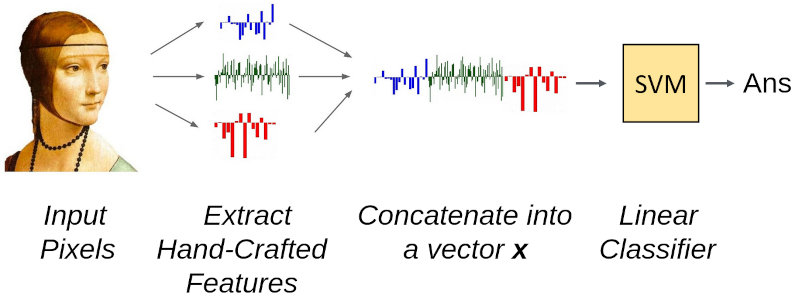

In the above code, the hand crafted features we extracted are the average of each colour band. We concatenate them, and our "Linear Classifier" is just a few if/else branches (we could call this a very simple decision tree). All computer vision tasks can be broken up into these main processing steps with different algorithms for finding features and classifiers. So, next, we will look at extracting common image features. Then we will look at different linear classifiers. Finally, we will put them together again on a standard image classification task.

## 2.3 Colour Moments

The first three moments of a distribution are: mean, standard deviation and skewness. You have already calculated the mean for green and red.

**Task**: Look at the docs for [numpy.mean()](https://numpy.org/doc/1.20/reference/generated/numpy.mean.html) and [numpy.std()](https://numpy.org/doc/1.20/reference/generated/numpy.std.html), especially the examples. Find the mean and standard deviations _per colour channel_ by only changing the arguments to `mean()` and `std()` in the below code.

In [ ]:
fname, img = dataset[0]
means = img.mean()
stds = img.std()
print(means)
# should be: [116.26533529 134.68638021 145.60429036]

print(stds)
# should be: [54.18954368 57.6412593  59.4558043 ]

#### Task solution

In [ ]:
fname, img = dataset[0]
means = img.mean(axis=(0,1))
stds = img.std(axis=(0,1))
print(means)
print(stds)

### Image patch/Window statistics

We can collect more fine-grained information from the image by breaking it up into patches and calculating these statistics for each patch. In this way, we can represent our image in fewer datapoints than just using pixel values, but without reducing the whole image to a single number.

**Task**: Run the cell below that uses `image_patches()` to break the images up into patches and look at the printed shapes. Then modify the code to take the means/stds for each patch as indicated.

**Note**: The terms "cell", "block", "texture", "image patch" and "window" are mostly interchangeable. They all mean "a subset of an image". With some nuance:
 - "window" is often short for "sliding window" which means that they are overlapping views of your image.
 - "texture" has special meaning in 3D applications: usually a specific type of file.
 - "cells" are the smallest unit if you have several levels.

These are not hard and fast rules. When talking about these things it's more important you are consistent.

In [ ]:
def image_patches(img, p_size=(80, 80)):
    '''
    Splits img up into equal sized, non-overlapping patches.
    Ignores partial patches at the edge of the img.
    '''
    rows = img.shape[0]//p_size[0]
    cols = img.shape[1]//p_size[1]
    blocks = []
    for r in range(rows):
        for c in range(cols):
            y_min = r*p_size[0]
            y_max = y_min+p_size[0]
            x_min = c*p_size[1]
            x_max = x_min+p_size[1]
            b = img[y_min:y_max, x_min:x_max]
            blocks.append(b)
    return np.array(blocks).reshape((rows, cols, *p_size, -1))

In [ ]:
colour_means = []
colour_stds = []
for fname, img in dataset:
    as_patches = image_patches(img)
    print(img.shape, as_patches.shape)
    # TODO - calculate the mean/std per patch
    # HINT: patch_mean should be shaped (8, 6, 3)

    # TODO - uncomment
    #colour_means.append(patch_mean)
    #colour_stds.append(patch_std)

#### Task solution

In [ ]:
colour_means = []
colour_stds = []
for fname, img in dataset:
    as_patches = image_patches(img)
    print(as_patches.shape)
    # Calculate the mean/std per window
    patch_mean = as_patches.mean(axis=(2,3))
    patch_std = as_patches.std(axis=(2,3))
    colour_means.append(patch_mean)
    colour_stds.append(patch_std)

#### Question
<b>Question</b>: After completing the previous task, how many features do we have for each image in <code>colour_means</code>?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    Each image has been reduced from 640x480x3=921600 pixel colours to 8x6x3=144 features of <code>colour_means</code> (288 if you include <code>colour_stds</code>). This can greatly simplify methods of creating decision boundaries.
</details>

## 2.4 Grey-Level Co-occurence Matrix (GLCM)

Grey-Level Co-occurance Matrices (GLCMs) are a way to collect statistics about how much contrast there is between neighbouring pixels in an image. Thus, GLCM is a good way to distinguish textures from one another. A texture is usually a small patch of an image, but we can use the same process on an entire image at once to create global features for image classification, too.

**In your own time**: Here's a longer tutorial on using [skimage.feature.greycomatrix()](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycomatrix) and [skimage.feature.greycoprops()](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycoprops): https://www.youtube.com/watch?v=5x-CIHRmMNY

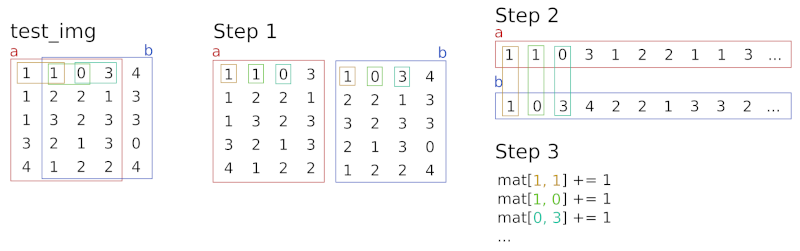

**Task**: Refer to the lectures and the outline above, and calculate the GLCM yourself. Ensure it gives the same output as [skimage.feature.graycomatrix()](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycomatrix).

  1. Index `img` to obtain two views, offset by the `distance`.
  2. Flatten/reshape.
  3. Count instances.

In [ ]:
test_img = np.array([
    [1, 1, 0, 3, 4],
    [1, 2, 2, 1, 3],
    [1, 3, 2, 3, 3],
    [3, 2, 1, 3, 0],
    [4, 1, 2, 2, 4]
], dtype=np.uint8)

def glcm(img, distance=1):
    ''' The Grey-Level Co-occurance Matrix of img'''
    mat = np.zeros((256, 256))
    # Step 1 + 2

    for i in range(len(a)):
        # Step 3

    return mat

In [ ]:
my_mat = glcm(test_img)
expected_mat = skimage.feature.graycomatrix(test_img, distances=[1], angles=[0]).squeeze()
print(expected_mat[:5, :5])

assert (my_mat == expected_mat).all()

#### Task solution

In [ ]:
def glcm(img, distance=1):
    ''' The Grey-Level Co-occurance Matrix of img'''
    mat = np.zeros((256, 256))
    a = img[:, :-distance].reshape(-1)
    b = img[:, distance:].reshape(-1)

    for i in range(len(a)):
        mat[a[i], b[i]] += 1

    return mat

### Matrix to features

We do not use the co-occurance matrix as features directly. Instead, we can collect statistics from the co-occurance matrix about the differences in intensity across the patch. Specific use cases will use each statistic more or less effectively, but that is a discussion outside the scope of this lab, so we won't go into exactly how to calculate these statistics. If you are interested, we refer you to pg 25 onwards of [an in-depth tutorial](https://prism.ucalgary.ca/bitstream/handle/1880/51900/texture%20tutorial%20v%203_0%20180206.pdf?sequence=11&isAllowed=y) on collecting GLCM features.

It is also recommended that when collecting GLCM features, you collect at a few scales and directions. In the above `glcm()` function we set a `distance=1` parameter. The `graycomatrix()` function allows you to specify a list of distances and angles to use.

**Task**: Using [skimage.feature.graycomatrix()](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycomatrix) and [skimage.feature.graycoprops()](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycoprops) complete the below code to collect the whole-image statistics for all images in our toy dataset at distances of `1`, `3` and `5`, and angles of `0`, `pi/2`, and `pi`.

In [ ]:
stat_names = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
glcm_features = []
for _, img in dataset:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # TODO - collect all stats for this image into an img_features variable

    glcm_features.append(img_features)

#### Task solution

In [ ]:
for _, img in dataset:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cov = skimage.feature.graycomatrix(img_gray, distances=[1, 3, 5], angles=[0, math.pi/2, math.pi])
    img_features = [skimage.feature.graycoprops(cov, stat_name) for stat_name in stat_names]
    glcm_features.append(img_features)

#### Question

<b>Question</b>: After completing the previous task, how many features do we have for each image in <code>glcm_features</code>?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    Each image has been reduced from 640x480x3=921600 pixel colours to 6 statistics collected with 9 different offsets (3 distances, 3 angles). Thus there are 6x9=54 features to describe each image.
</details>

## 2.5 Histogram of Oriented Gradients (HOG)

Histogram of Oriented Gradients is a classic technique to produce characteristic image features based on the shapes of objects. To start, let's break down the words:

  - Histogram: We are counting something, and binning them together.
  - Oriented: We care about the angle.
  - Gradients: In an image, a gradient indicates an edge.
  
So, Histograms of Oriented Gradients will find edges and count how many of them there are at each orientation. All applications of HOG find histograms within image patches. Thus this is built into the library function [skimage.feature.hog()](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog), too.

**Task**: Modify the below code to use image patches of 16x16 (instead of the default 8x8).

In [ ]:
hogs = []
viss = []
for fname, img in dataset:
    hog, vis = skimage.feature.hog(img, feature_vector=False, visualize=True, channel_axis=2)
    hogs.append(hog)
    viss.append(vis)

print(hogs[0].shape)

In [ ]:
fig, axes = plt.subplots(2, len(hogs), figsize=(25, 15))
for i, ((fname, img), vis) in enumerate(zip(dataset, viss)):
    # Original
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(fname)

    # HOG visualisation
    axes[1, i].imshow(vis*1.5)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'{fname} HOG')

#### Task solution

In [ ]:
skimage.feature.hog(img, pixels_per_cell=(16, 16), feature_vector=False, visualize=True, channel_axis=2)

#### Questions

<b>Question</b>: How many orientation bins are there? (Hint: read docs)

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    There are 9 orientation bins.
</details>

<br />

<b>Question</b>: After running the above code, how many features do we have for each image in `hogs`?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    Each image has been reduced from 640x480x3=921600 pixel colours to 78x58x3x3x9=366444 features! There are 9 orientation bins. Generally, we use HOG on a smaller image. It was originally defined for pedestrian detection, and is optimised for finding a 128x64 image of a person. You would generally tweak the parameters for whatever task you work on.
</details>

# 3. CIFAR-10

We've been ignoring a problem. Our toy dataset does not have enough images to properly test our image features. In Section 2.1 we saw that we could perfectly classify our 4 images with just the mean green/red values. But, what happens if we have 60000 images?

Introducing CIFAR-10. It is a dataset of small images that are classified into 10 classes. It is a standard image benchmark/dataset used widely in computer vision. We will use CIFAR-10 to try out some of the image features we have used previously. Take some time to explore the classes and the images.

(**Note**: downloading CIFAR-10 needs about 350MB of free harddrive space)

In [ ]:
# Download CIFAR10
cifar = torchvision.datasets.CIFAR10('./cifar10', download=True)

# Display the first 32 images from CIFAR10
fig = plt.figure(figsize=(10, 5))
for i in range(32):
    img, lbl = cifar[i]
    # Each img is a PIL object. Don't worry; we can just turn it into a numpy array.
    img = np.array(img)
    # Each lbl is just an integer. The cifar object has the class names.
    img_class = cifar.classes[lbl]

    ax = plt.subplot(4, 8, i+1)
    ax.axis('off')
    ax.set_title(img_class)
    ax.imshow(img)
fig.tight_layout()

# 4. Classifiers

A classifier is essentially a function which takes a set of features and predicts a class label. Classifiers are generally created via machine learning. That is, we must provide them with a set of images and true labels to "train" them. A trained classifier will tend to only do well on images that are similar to the training images in some way. For example, we should not expect a classifier for CIFAR-10 to give us any meaningful result if we give it a picture of an MNIST digit.



In [ ]:
N_IMGS = 2000
lbls = []
for i in range(N_IMGS):
    img, lbl = cifar[i]
    lbls.append(lbl)
lbls = np.array(lbls)

In [ ]:
def classification_accuracy(predictions, lbls):
    return (predictions == lbls).sum()/len(predictions)

bad_predictions = np.zeros(N_IMGS) # always predict class 0
acc = classification_accuracy(bad_predictions, lbls[:N_IMGS])
print(acc)

**Question**: There are 10 classes in CIFAR-10. Thus, what accuracy should we expect to get if we randomly classify each image?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    Assuming CIFAR-10 is balanced, we should get 10% accuracy when choosing randomly.
</details>

## 4.1 Feature space

If we flatten an image, we get a vector. In the case of CIFAR-10, with 32x32 images, we can consider this image as a point in 3072-D space. This is impossible to visualise spatially. We can, instead, choose precisely 2 features to represent our images. We would then say that the images have been embedded in 2D feature space. Then, we can easily plot these features.

The code below goes through the first `N_IMGS` of CIFAR10, collecting all the image features we have previously discussed in this lab. Then it plots 2 of the features against each other. This code will take a while to run since it is processing many images.

In [ ]:
# These arrays will hold parallel lists of features such that
# green_means[i] is the mean green of the i-th image, etc.
green_means = []
blue_means = []
red_means = []
green_stds = []
blue_stds = []
red_stds = []
contrasts = []
dissimilarities = []
homogeneities = []
hogs = []

# Collect all features
for i in range(N_IMGS):
    img, lbl = cifar[i]
    img = np.array(img)

    # Colour moment features
    r, g, b = img.mean(axis=(0, 1))
    red_means.append(r)
    green_means.append(g)
    blue_means.append(b)
    r, g, b = img.std(axis=(0, 1))
    red_stds.append(r)
    green_stds.append(g)
    blue_stds.append(b)

    # GLCM features
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    cov = skimage.feature.graycomatrix(img_gray, distances=[1, 3, 5], angles=[0, math.pi/2, math.pi])
    contrasts.append(skimage.feature.graycoprops(cov, 'contrast'))
    dissimilarities.append(skimage.feature.graycoprops(cov, 'dissimilarity'))
    homogeneities.append(skimage.feature.graycoprops(cov, 'homogeneity'))

    # HOG features
    hog_f = skimage.feature.hog(img, channel_axis=2)
    hogs.append(hog_f)

# Normalising the features, and converting them all to numpy arrays for ease of use

def normalise(feature):
    feature = np.array(feature)
    return (feature-feature.min())/(feature.max()-feature.min())

green_means = normalise(green_means)
blue_means = normalise(blue_means)
red_means = normalise(red_means)
green_stds = normalise(green_stds)
blue_stds = normalise(blue_stds)
red_stds = normalise(red_stds)

contrasts = normalise(contrasts)
dissimilarities = normalise(dissimilarities)
homogeneities = normalise(homogeneities)

# HOG features are already normalised
hogs = np.array(hogs)

# For the following, there are many features created per image.
# Currently contrasts[i] is the vector of contrast features of image i.
# We want contrasts[i] to be the i-th contrast feature, over all images.
contrasts = contrasts.reshape([N_IMGS, -1]).transpose()
dissimilarities = dissimilarities.reshape([N_IMGS, -1]).transpose()
homogeneities = homogeneities.reshape([N_IMGS, -1]).transpose()
hogs = hogs.transpose()


# Arbitrarily choose green_means and red_means to represent our images for visualisation
plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
for i in range(len(cifar.classes)):
    idx = (lbls == i)
    ax.scatter(green_means[idx], red_means[idx], label=cifar.classes[i])
ax.legend()
ax.set_xlabel('green means (normalised)')
_ = ax.set_ylabel('red means (normalised)')

<b>Question</b>: What does each dot in the scatter plot represent?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    Each dot is an image, reduced to two features and plotted on a cartesian plane. The image is "in feature space", which we have visualised.
</details>

<br />

<b>Question</b>: Can you draw a straight line to separate most of the blue dots from most of the lime green dots?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    No. This means that there is no combination of if/else blocks with simple "green > a" or "red > b" conditions which will classify these images well.
</details>

<br />

<b>Question</b>: What can do we do about this?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    Use more features and use more sophisticated features, such as we have gone through previously.
</details>

### Graphically comparing discriminative power

The discriminative power of a set of features is, roughly speaking, the extent to which we can linearly separate the images in feature space using those features. We're not going to find a perfect pair of features, but we can do better than the average green vs average red.

We will now explore various combinations of two features and observe their discriminative power on pairs of classes from CIFAR. If we can't separate even two classes, we certainly can't separate all of the classes.

In [ ]:
# Helper functions to visualise discriminative power
# If you want to read these to understand them, come back after the section on SVMs.

def plot_decision_regions(x, y, svm, ax, border=0):
    '''
    Colours regions on ax by sampling a dense grid of the space
    and predicting a class with the provided svm.
    '''
    # https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

    # Make a meshgrid that covers the whole space
    x_min, x_max = x.min()-border, x.max()+border
    y_min, y_max = y.min()-border, y.max()+border
    n = 200 # number of samples
    h_x = (x_max-x_min)/n
    h_y = (y_max-y_min)/n
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))

    # Make a prediction per spot in that space
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the space as a surface with coloured regions
    ax.contourf(xx, yy, Z, alpha=0.2, antialiased=True)

def compare_discriminative_power(feature1, feature2, lbls, n=4):
    '''
    Plots an nxn grid of pairs of labels from cifar.classes,
    showing each image as a point in the 2D feature space, coloured by it's lbl.
    '''
    features = np.stack([feature1, feature2], axis=-1)
    plt.figure(figsize=(5*n, 5*n))
    for lbl_1 in range(n):
        for lbl_2 in range(10-n, 10):
            # Find index into features and lbls for this pair of labels
            idx1 = (lbls == lbl_1)
            idx2 = (lbls == lbl_2)
            idx = (idx1 | idx2)

            # Train an SVM for this pair of labels on these features
            svm = sklearn.svm.SVC(kernel='linear')
            f_idx = features[idx]
            l_idx = lbls[idx]
            svm.fit(f_idx, l_idx)

            # Plot
            ax = plt.subplot(n, n, lbl_1*n+lbl_2-(10-n)+1)
            plot_decision_regions(feature1[idx], feature2[idx], svm, ax)
            ax.scatter(feature1[idx1], feature2[idx1], label=cifar.classes[lbl_1])
            ax.scatter(feature1[idx2], feature2[idx2], label=cifar.classes[lbl_2])
            ax.legend()
            ax.axis('off')

            # Show accuracy on plot
            pred = svm.predict(f_idx)
            accuracy = classification_accuracy(pred, l_idx)
            ax.text(ax.get_xlim()[0], ax.get_ylim()[1]*1.01, f'{(accuracy*100):5.2f}%', fontsize=13)

Now we can easily compare the discriminative power of pairs of features on pairs of classes.

**Task**: Try a few combinations of two features in the below cell. Try to find discriminative pairs. Choose pairs of:
- `green_means`
- `green_stds`
- `red_means`
- `red_stds`
- `blue_means`
- `blue_stds`
- `contrasts[x]`
- `dissimilarities[x]`
- `homogeneities[x]`
- `hogs[x]`

In [ ]:
compare_discriminative_power(green_means, red_means, lbls)

<b>Question</b>: Did you find any combinations that resulted in linearly separable classes?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    I (the tutor) didn't find anything close. There's quite a few that are around 77%. I don't think any of these pairs will get close to 100%. This tells us that we haven't found any combination of two features which are really good for classification of two classes of CIFAR. <i>Note</i>: Randomly classifying between two classes gets 50% accuracy.
    <br />
    The <b>real</b> test is going to be discriminating between all 10 classes using all of the features.
</details>

## 4.2 Support Vector Machine (SVM)

A Support Vector Machine (SVM) is a popular machine learning classifier. In previous sections, we said "imagine putting a straight line on these graphs to separate these classes". An SVM is a method to do that systematically, for any number of classes, and in higher dimensions. In the above helper code, we have used a linear SVM to create the coloured regions.

More formally, an SVM finds a hyperplane (i.e. an (N-1)-D plane) through your N-dimensional data, segmenting the space and assigning each segment to a class, and classification is performed by placing an image into the feature space and querying which segment it ended up in. The hyperplane is chosen so that it minimises the distance for misclassifications. While we have 2D data the SVM finds a 1D line to separate the data.

That's fairly complicated, so let's go through a few small examples using [sklearn's SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), building up complexity. We won't cover how it works internally, but we will cover how to use it.

In [ ]:
def visualise_svm(features, lbls, svm):
    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(1, 1, 1)
    plot_decision_regions(features[:, 0], features[:, 1], svm, ax, border=1)

    for i in range(fake_lbls.max()+1):
        idx = (fake_lbls == i)
        ax.scatter(features[idx, 0], features[idx, 1], label=i)
    ax.legend()
    return ax

# First, we'll cover the basics of instantiating an SVM from sklearn
fake_data = np.array([[0, 0], [1, 1]])
fake_lbls = np.array([0, 1])

svm = sklearn.svm.SVC(kernel='linear')
svm.fit(fake_data, fake_lbls)

ax = visualise_svm(fake_data, fake_lbls, svm)

## Task 1

**Task**: Reading from the above graph, write down whether each of the following points will be classified as class 0 or class 1 using the `svm` from the previous cell. Then, test your predictions in the next cell:

 - (0.2, 0.2)
 - (0.5, 0.6)
 - (0.6, 0.3)

In [ ]:
new_fake_data = #np.array([[]])
result = svm.predict(new_fake_data)
print(result)
# TODO - Write your predictions down (on paper, or here)

#### Task solution

In [ ]:
new_fake_data = np.array([
    [0.2, 0.2],
    [0.5, 0.6],
    [0.6, 0.3],
])
result = svm.predict(new_fake_data)
print(result)

### Task 2

Next, let's look at a slightly more complicated example. We'll consider two normally distributed sets of points for an SVM to classify.

**Task**: Fit an SVM to `fake_features` and `fake_lbls`.

In [ ]:
# Let's pretend we have collected some image features for two classes
N = 400
fake_class1 = np.random.normal((-1, 0), 0.6, (N, 2))
fake_class2 = np.random.normal((0, 2), 0.6, (N, 2))
fake_features = np.concatenate([fake_class1, fake_class2], axis=0)
fake_lbls = np.array([0]*N + [1]*N)

# We can use a linear SVM to find a straight line that best separates them.
# TODO

# Visualise
ax = visualise_svm(fake_features, fake_lbls, svm)

#### Task solution

In [ ]:
svm = sklearn.svm.SVC(kernel='linear')
svm.fit(fake_features, fake_lbls)
ax = visualise_svm(fake_features, fake_lbls, svm)

### Task 3

**Task**: Modify the standard deviation of `fake_class1` and `fake_class2` to a value of `1.25` (don't change the mean) in the above code cell.

<b>Question</b>: What happens to the distributions?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
    The distributions spread out more and a straight line can no longer separate the two classes so well.
</details>

<br />

<b>Task</b>: Revert standard deviations to <code>0.6</code> as before the previous task. Add a <code>fake_class3</code> centred at (1, 0) with a std deviation of 0.5. <i>Hint</i>: You will need to also modify <code>fake_features</code> and <code>fake_lbls</code>.

#### Task solution

In [ ]:
# Let's pretend we have collected some image features for two classes
N = 400
fake_class1 = np.random.normal((-1, 0), 0.6, (N, 2))
fake_class2 = np.random.normal((0, 2), 0.6, (N, 2))
fake_class3 = np.random.normal((1, 0), 0.6, (N, 2))
fake_features = np.concatenate([fake_class1, fake_class2, fake_class3], axis=0)
fake_lbls = np.array([0]*N + [1]*N + [2]*N)

# We can use a linear SVM to find a straight line that best separates them.
svm = sklearn.svm.SVC(kernel='linear')
svm.fit(fake_features, fake_lbls)

# Visualise
ax = visualise_svm(fake_features, fake_lbls, svm)

### Evaluation

You have seen, roughly, how an SVM uses image features to classify images. So, finally, let's see how well an SVM does with our image feature set.

**Task**: Complete the following code to train an SVM on all of our image features. *Hint*: Use [np.stack()](https://numpy.org/doc/1.20/reference/generated/numpy.stack.html)

**Optional Task**: Use a different combinations of features. Try to get ~85% overall accuracy!

In [ ]:
features = # TODO should be shaped [N_IMGs, n_features]
print(features.shape)
print(lbls.shape)

# Train an SVM and get predictions
svm = sklearn.svm.SVC()
svm.fit(features, lbls)
preds = svm.predict(features)

# Evaluate
acc = classification_accuracy(preds, lbls)
print(f'{acc*100:5.2f}%')

#### Task solution

In [ ]:
features = np.stack([
    green_means,
    green_stds,
    blue_means,
    blue_stds,
    red_means,
    red_stds,
    *contrasts,
    *dissimilarities,
    *homogeneities,
    *hogs
], axis=-1)
print(features.shape)
print(lbls.shape)

# Train an SVM and get predictions
svm = sklearn.svm.SVC()
svm.fit(features, lbls)
preds = svm.predict(features)

# Evaluate
acc = classification_accuracy(preds, lbls)
print(f'{acc*100:5.2f}%')

In [ ]:
# Here, we will manually inspect the predictions
fig = plt.figure(figsize=(20, 20))
for i in range(64):
    img, lbl = cifar[i]
    img = np.array(img)
    lbl_class = cifar.classes[lbl]

    pred = preds[i]
    pred_class = cifar.classes[pred]

    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    ax.set_title(pred_class + (' (WRONG)' if pred != lbl else ''))
    ax.imshow(img)

### Kernel Trick

Most distributions are not linearly separable. Notice that we used `kernel='linear'` in all previous examples? Handling distributions that are not linearly separable is so common that it's built into `sklearn.svm.SVC`. We won't cover exactly how it is done, but there's a technique called "the kernel trick" which augments the data so that it becomes linearly separable, even if it wasn't to begin with.

**In your own time**: We refer you to [a good introductory article on SVMs and the kernel trick](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f)

**Task**: Modify the code below to use the `'rbf'` kernel. Compare how it segments the space to the `'linear'` kernel.

In [ ]:
fake_data = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])/4
fake_lbls = np.array([0, 1, 0, 1])

svm = sklearn.svm.SVC(kernel='linear')
svm.fit(fake_data, fake_lbls)
preds = svm.predict(fake_data)
print(preds)

ax = visualise_svm(fake_data, fake_lbls, svm)

## 4.3 KNN classification

K-nearest neighbours is a very simple, yet powerful classifier. Once you have embedded your images in feature space, find the K nearest images, and whatever is the most popular class in those K images is what you classify the new image as.

The biggest downside to KNN is that it becomes more expensive to compute as you collect more data. Modern computer vision algorithms require huge amounts of data to ensure that we can generalise to unseen examples, so, unfortunately, we often can't use KNN in practice.

The syntax for using [sklearn's KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) is almost identical to using SVMs

**Task**: Evaluate using KNN as the classifier on our image features. You can expect to achieve a classification accuracy of around 65% when using all image features.

In [ ]:
features = # TODO
print(features.shape)
print(lbls.shape)

# Train a KNN and get predictions
knn = # TODO

# Evaluate
acc = classification_accuracy(preds, lbls)
print(f'{acc*100:5.2f}%')

#### Task solution

In [ ]:
features = np.stack([
    green_means,
    green_stds,
    blue_means,
    blue_stds,
    red_means,
    red_stds,
    *contrasts,
    *dissimilarities,
    *homogeneities,
    *hogs
], axis=-1)
print(features.shape)
print(lbls.shape)

# Train a KNN and get predictions
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(features, lbls)
preds = knn.predict(features)

# Evaluate
acc = classification_accuracy(preds, lbls)
print(f'{acc*100:5.2f}%')

# Summary

In this lab, we covered the basics of extracting features from images for classification. We framed every computer vision task as involving two main steps: 1. collecting image features and then 2. using those features with a classifier. We explored a few popular features and classifiers. It is important to note that there are many more image features and classifiers out there and there is no single best feature or classifier, you must explore and find the best for any task. But hopefully this lab gives you a starting point.

# Next lab

We will investigate a recently popularised algorithm that combines image features and a classifier: a "Convolutional Neural Network" (CNN).